In [1]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.3. Cluster Analysis/Output'
cur_date = '020526'

library(readxl)
library(tidyverse)
library(reshape2)
library(vegan)
library(ecodist)

# reading in files
full_df = data.frame(read_excel("Input/Processed_Data_020226.xlsx")) 
wf_info_df = data.frame(read_excel("Input/Study_Info_WF_012226.xlsx", sheet = 2))[,1:12]
ws_info_df = data.frame(read_excel("Input/Study_Info_WS_012226.xlsx", sheet = 2))[,1:15]
ws_info_df$HAWC_ID = as.character(ws_info_df$HAWC_ID)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: permute


Attaching package: ‘ecodist’


The following objects are masked from ‘package:vegan’:

    mantel, pco




In [2]:
head(full_df)
head(wf_info_df)
head(ws_info_df)

,HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Metal,Ca,Calcium,8.5961898
2,1289889,Volume,WF,Scaramboni et al. 2024,1,1289889_1,Metal,Ca,Calcium,2.9319259
3,1289889,Volume,WF,Scaramboni et al. 2024,2,1289889_2,Metal,Ca,Calcium,2.9319259
4,1289889,Volume,WF,Scaramboni et al. 2024,1,1289889_1,Metal,Ni,Nickel,0.6959938
5,1289889,Volume,WF,Scaramboni et al. 2024,2,1289889_2,Metal,Ni,Nickel,0.2986583
6,1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Metal,Ni,Nickel,0.5464964


,HAWC_ID,Study,Sample_Number,Study_Sample_ID,Class,Metric,Fire_Type,Location,PM_Size,Sample_Matrix,Fuel_Species,Fuel_Type
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1289737,Campbell et al. 2024,1,1289737_1,PAH,Weight,Natural,Wooded,NA,Ash,Eucalyptus,Hardwood
2,1289739,Campos et al. 2019,1,1289739_1,PAH,Weight,Natural,Wooded,NA,Ash,Eucalyptus,Hardwood
3,1289739,Campos et al. 2019,2,1289739_2,PAH,Weight,Natural,Wooded,NA,Ash,Eucalyptus,Hardwood
4,1289739,Campos et al. 2019,3,1289739_3,PAH,Weight,Natural,Wooded,NA,Ash,Eucalyptus,Hardwood
5,1289739,Campos et al. 2019,4,1289739_4,PAH,Weight,Natural,Wooded,NA,Ash,Eucalyptus,Hardwood
6,1289739,Campos et al. 2019,5,1289739_5,PAH,Weight,Natural,Wooded,NA,Ash,Pine,Softwood


,HAWC_ID,Study,Sample_Number,Study_Sample_ID,Class,Metric,Source,Combustion_Condition,PM_Size,Sample_Matrix,Fuel_Species,Sample_Origin,Fuel_Type,Efficiency,Fuel_Size
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,429174,Arif et al. 2017,1,429174_1,PAH,Weight,Boiler,NA,Very fine,PM,Mixed,Smoke,Softwood,Medium,Chip
2,429174,Arif et al. 2017,2,429174_2,PAH,Weight,Boiler,NA,Very fine,PM,Beech,Smoke,Hardwood,Medium,Chip
3,298566,Jalava et al. 2010,1,298566_1,PAH,Weight,Masonry heater,Normal,Very fine,PM,Birch,Flue gas,Hardwood,Medium,Log
4,298566,Jalava et al. 2010,2,298566_2,PAH,Weight,Masonry heater,Normal,Very fine,PM,Birch,Flue gas,Hardwood,Medium,Log
5,298566,Jalava et al. 2010,3,298566_3,PAH,Weight,Masonry heater,Smoldering,Very fine,PM,Birch,Flue gas,Hardwood,Medium,Log
6,298566,Jalava et al. 2010,4,298566_4,PAH,Weight,Masonry heater,Smoldering,Very fine,PM,Birch,Flue gas,Hardwood,Medium,Log


# Principal Coordinate Analysis (PCoA)

A dimensionality reduction technique that measures disimilarity using non-Euclidean distance matrices between each pair of studies. Eigenvalues are then computed from these matrices. 

In [3]:
# splitting based on metric
metric_split = full_df %>%
    group_by(Metric) %>%
    group_split()

vol_df = metric_split[[1]]
weight_df = metric_split[[2]]

In [36]:
# wide matrix: samples x constituents
wide_vol_df = vol_df %>%
    group_by(Study_Sample_ID, DTXSID) %>%
    summarize(Value = mean(Value, na.rm = TRUE), .groups = "drop") %>%
    pivot_wider(names_from = DTXSID, values_from = Value) %>%
    column_to_rownames('Study_Sample_ID')
wide_weight_df = weight_df %>%
    group_by(Study_Sample_ID, DTXSID) %>%
    summarize(Value = mean(Value, na.rm = TRUE), .groups = "drop") %>%
    pivot_wider(names_from = DTXSID, values_from = Value) %>%
    column_to_rownames('Study_Sample_ID')

# Missing-by-design: treat as 0 for Bray–Curtis (no imputation beyond "not observed")
wide_vol_df[is.na(wide_vol_df)] <- 0
wide_weight_df[is.na(wide_weight_df)] <- 0

head(wide_vol_df)

,Ca,Cu,Fe,K,Mn,Ni,Pb,Sr,Zn,DTXSID0022432,DTXSID2020139,DTXSID3024104,DTXSID3024289,DTXSID5023908,DTXSID6024254
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1070627_1,10.421118,7.000000,10.124121,9.915282,5.906891,6.601399,6.285402,0.00000,7.452035,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1070627_2,9.219653,4.412782,8.741467,9.252429,3.711495,3.217231,2.536053,0.00000,5.364572,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1263480_1,18.892083,13.550867,15.383671,21.618070,13.550867,0.000000,12.425478,12.77335,18.116806,14.07439,16.70051,19.15870,19.39310,16.06384,20.99731
1263480_2,18.694559,13.340963,14.587895,20.074637,13.074476,10.426265,0.000000,12.72089,20.306748,20.38390,18.41184,20.86193,20.99938,18.37836,22.78409
1263480_3,17.693712,0.000000,13.287857,18.800258,13.823865,0.000000,13.287857,12.55099,17.227889,19.73397,17.15562,19.92940,19.96579,17.31009,22.01886
1263484_1,0.000000,0.000000,15.985286,21.407453,12.765079,12.036517,14.733492,0.00000,15.168633,16.74716,15.87270,18.84230,18.71398,14.87272,20.61863


In [5]:
# setting seed for reproducibility
set.seed(12)

# Bray–Curtis distance
bc_vol_df = vegdist(wide_vol_df, method = "bray")
bc_weight_df = vegdist(wide_weight_df, method = "bray")

# PCoA
pcoa_vol = pco(bc_vol_df)
pcoa_weight = pco(bc_weight_df)

# getting first two dimensions and adding back in meta data
pcoa_vol_df = data.frame('Study_Sample_ID' = rownames(wide_vol_df), PC1 = pcoa_vol$vectors[,1], 
                                  PC2 = pcoa_vol$vectors[,2]) %>%
    inner_join(vol_df[,c(3,6:8)]) %>%
    left_join(wf_info_df) %>%
    left_join(ws_info_df)

pcoa_weight_df = data.frame('Study_Sample_ID' = rownames(wide_weight_df), PC1 = pcoa_weight$vectors[,1], 
                                  PC2 = pcoa_weight$vectors[,2]) %>%
    inner_join(weight_df[,c(3,6:8)]) %>%
    left_join(wf_info_df) %>%
    left_join(ws_info_df)

head(pcoa_vol_df)

Joining with `by = join_by(Study_Sample_ID)`
Joining with `by = join_by(Study_Sample_ID, Class)`
Joining with `by = join_by(Study_Sample_ID, Class, HAWC_ID, Study,
Sample_Number, Metric, PM_Size, Sample_Matrix, Fuel_Species, Fuel_Type)`
Joining with `by = join_by(Study_Sample_ID)`
Joining with `by = join_by(Study_Sample_ID, Class)`
Joining with `by = join_by(Study_Sample_ID, Class, HAWC_ID, Study,
Sample_Number, Metric, PM_Size, Sample_Matrix, Fuel_Species, Fuel_Type)`


,Study_Sample_ID,PC1,PC2,Sample,Class,DTXSID,HAWC_ID,Study,Sample_Number,Metric,⋯,Location,PM_Size,Sample_Matrix,Fuel_Species,Fuel_Type,Source,Combustion_Condition,Sample_Origin,Efficiency,Fuel_Size
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1070627_1,-0.4962629,0.05642864,WF,Metal,Sr,1070627,Siregar et al. 2022,1,Volume,⋯,Urban air samples from wooded wildfire,Coarse and fine,Air samples,Air,NA,NA,NA,NA,NA,NA
2,1070627_1,-0.4962629,0.05642864,WF,Metal,Ca,1070627,Siregar et al. 2022,1,Volume,⋯,Urban air samples from wooded wildfire,Coarse and fine,Air samples,Air,NA,NA,NA,NA,NA,NA
3,1070627_1,-0.4962629,0.05642864,WF,Metal,Cu,1070627,Siregar et al. 2022,1,Volume,⋯,Urban air samples from wooded wildfire,Coarse and fine,Air samples,Air,NA,NA,NA,NA,NA,NA
4,1070627_1,-0.4962629,0.05642864,WF,Metal,Fe,1070627,Siregar et al. 2022,1,Volume,⋯,Urban air samples from wooded wildfire,Coarse and fine,Air samples,Air,NA,NA,NA,NA,NA,NA
5,1070627_1,-0.4962629,0.05642864,WF,Metal,Pb,1070627,Siregar et al. 2022,1,Volume,⋯,Urban air samples from wooded wildfire,Coarse and fine,Air samples,Air,NA,NA,NA,NA,NA,NA
6,1070627_1,-0.4962629,0.05642864,WF,Metal,Mn,1070627,Siregar et al. 2022,1,Volume,⋯,Urban air samples from wooded wildfire,Coarse and fine,Air samples,Air,NA,NA,NA,NA,NA,NA


## Permutational Multivariate Analysis of Variance (PERMONOVA)

PERMONOVA is a non-parametric statistical method used to test for significant differences in community structure or multivariate data across groups.

In [9]:
head(per_vol_df)
levels(per_vol_df$Sample)
levels(per_weight_df$Sample)

,Sample,Ca,Cu,Fe,K,Mn,Ni,Pb,Sr,Zn,DTXSID0022432,DTXSID2020139,DTXSID3024104,DTXSID3024289,DTXSID5023908,DTXSID6024254
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1289889_3,WF,8.596190,6.781360,7.247928,9.491853,1.448901,0.5464964,0.8718436,0,0,0.07997538,0.1256511,0.1557492,0.1123665,0.214124805,0.0772430
1289889_1,WF,2.931926,6.221104,9.609179,9.612868,3.666757,0.6959938,2.9164766,0,0,0.40925515,0.9568001,0.5350576,0.5300707,1.572404647,0.2116353
1289889_2,WF,2.931926,4.887525,8.629357,9.459432,2.558268,0.2986583,2.0426443,0,0,0.30451104,0.5607150,0.3010023,0.3459640,1.261229909,0.1137005
1426391_1,WF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000000,0.0000000,0,0,0.64800518,0.1953476,2.1890338,3.0959244,0.073408955,5.1043367
1426391_2,WF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000000,0.0000000,0,0,0.08224829,0.4419814,0.4005379,0.5048746,0.002032767,2.0391384
1426391_3,WF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000000,0.0000000,0,0,0.01409816,0.4419814,0.2785796,0.2326608,0.001026833,1.7268312


[1] "WS" "WF"

[1] "WS" "WF"

In [39]:
per_vol_df = inner_join(vol_df[,c(6,3)], wide_vol_df %>%
                       rownames_to_column(var = 'Study_Sample_ID')) %>%
    unique() %>% 
    remove_rownames() %>%
    arrange(Study_Sample_ID) %>%
    column_to_rownames('Study_Sample_ID') %>%
    mutate(Sample = relevel(factor(ifelse(Sample == "WF", 'WF', 'WS')), ref = "WS")) 

per_weight_df = inner_join(weight_df[,c(6,3)], wide_weight_df %>%
                       rownames_to_column(var = 'Study_Sample_ID')) %>%
    unique() %>% 
    remove_rownames() %>%
    arrange(Study_Sample_ID) %>%
    column_to_rownames('Study_Sample_ID') %>%
    mutate(Sample = relevel(factor(ifelse(Sample == "WF", 'WF', 'WS')), ref = "WS")) 

vol_permonova =  adonis2(bc_vol_df ~ Sample, data = per_vol_df, permutations = 999)
weight_permonova =  adonis2(bc_weight_df ~ Sample, data = per_weight_df, permutations = 999)

Joining with `by = join_by(Study_Sample_ID)`
Joining with `by = join_by(Study_Sample_ID)`


In [24]:
vol_permonova
weight_permonova

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,1,1.853744,0.2063827,6.501329,0.001
Residual,25,7.128328,0.7936173,NA,NA
Total,26,8.982073,1.0000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,1,5.126551,0.1853438,20.70356,0.001
Residual,91,22.533133,0.8146562,NA,NA
Total,92,27.659684,1.0000000,NA,NA


Based on these results from PERMONOVA, WS and WF showed statistically significant global differences in both volume and weight samples (p value < 0.05).

Getting variance of the first two eigenvectors.

In [10]:
# obtaining eigenvalues and making them positive
eig_vol = pcoa_vol$values
pos_eig_vol = eig_vol[eig_vol > 0]

eig_weight = pcoa_weight$values
pos_eig_weight = eig_weight[eig_weight > 0]

# calculating percentage for each eigenvector
variance_percentage_vol = (pos_eig_vol / sum(pos_eig_vol)) * 100
variance_percentage_weight = (pos_eig_weight / sum(pos_eig_weight)) * 100
variance_percentage_vol[1:2]
variance_percentage_weight[1:2]

[1] 42.59686 18.54816

[1] 36.17074 25.17736

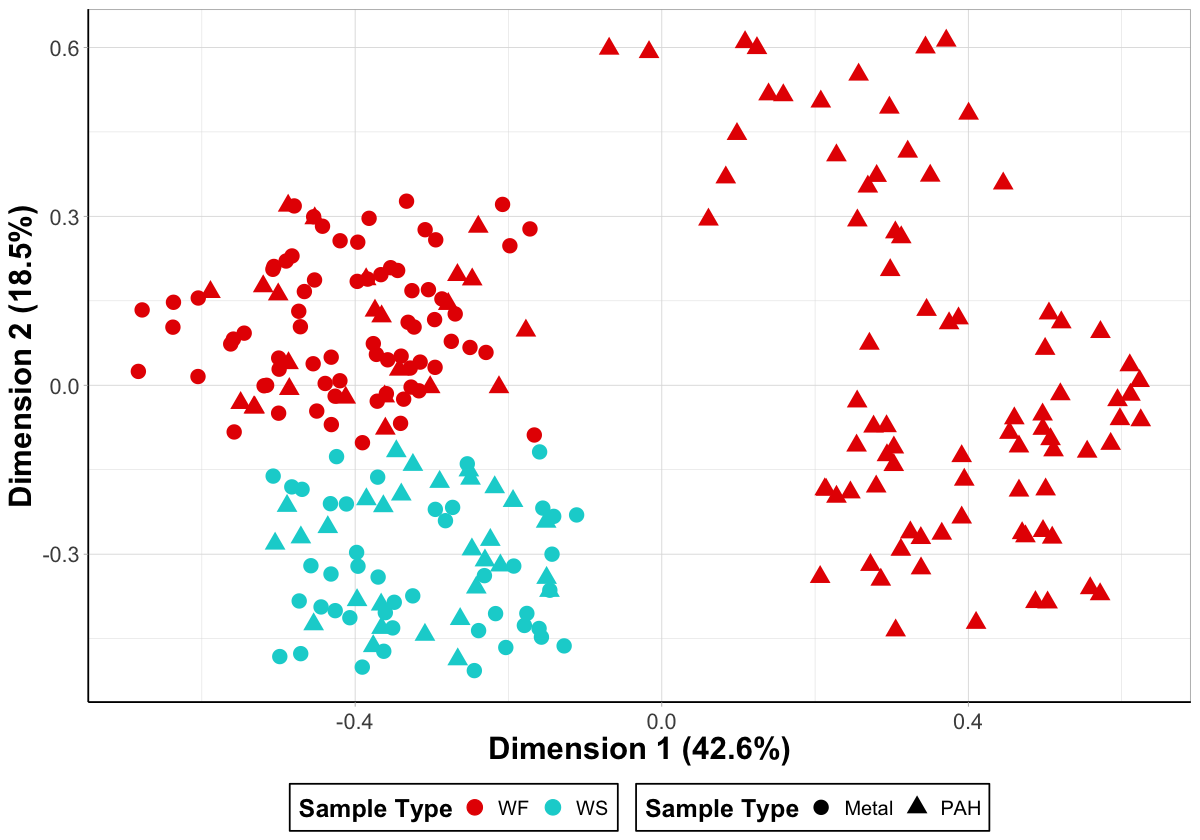

In [11]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
vol_pca_figure = ggplot() + 
  geom_point(data = pcoa_vol_df, aes(x = PC1, y = PC2, color = Sample, shape = Class),
             size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  # stat_ellipse(data = pcoa_vol_df, aes(x = PC1, y = PC2, color = Sample)) + 
  # geom_text_repel(data = full_eigenvector_df %>%
  #          filter(Metric == 'Volume', PC1 > 5), 
  #                 aes(x = PC1, y = PC2, color = Sample, label = SampleID), 
  #                 segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (42.6%)', y = 'Dimension 2 (18.5%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c('#e60000', '#00d2d2'))

vol_pca_figure

The chemical and metal volume profiles are very different between wildfire and woodsmoke studies, but also within wildfire studies.

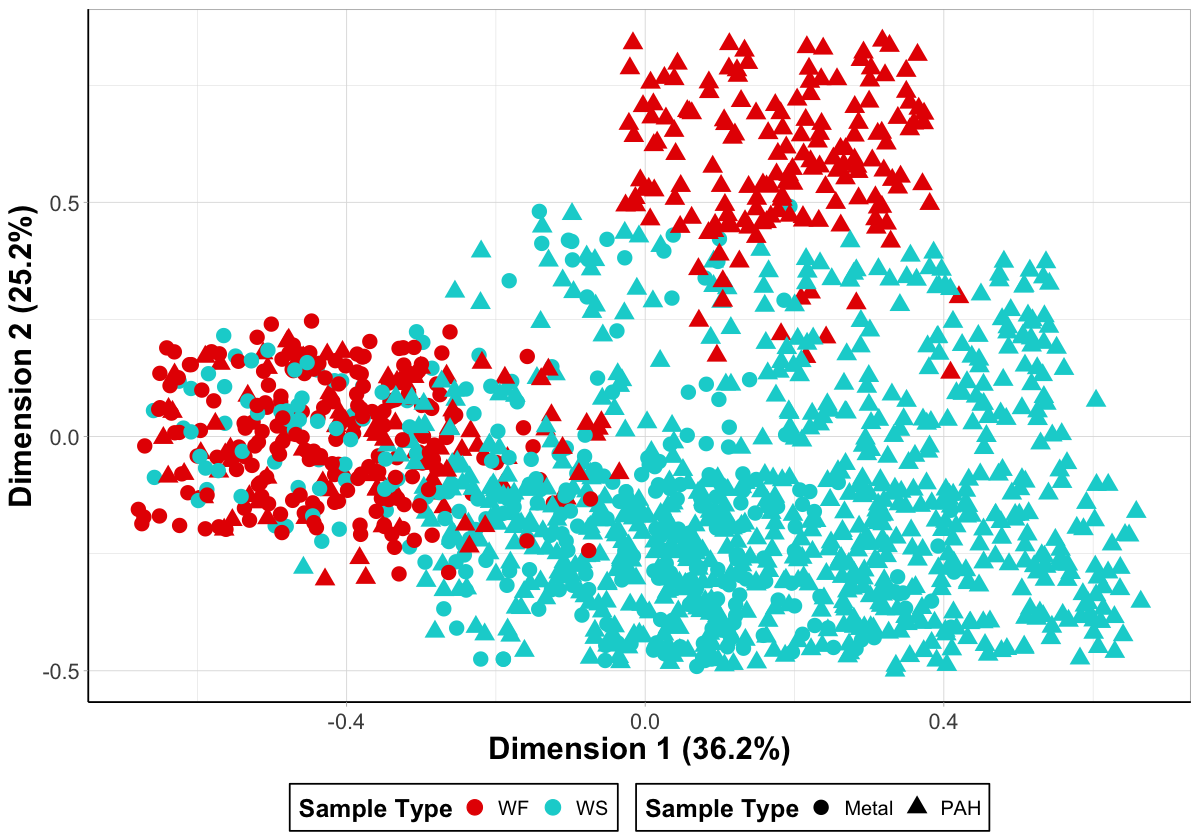

In [27]:
weight_pca_figure = ggplot() + 
  geom_point(data = pcoa_weight_df, aes(x = PC1, y = PC2, color = Sample, shape = Class),
             size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  # stat_ellipse(data = pcoa_vol_df, aes(x = PC1, y = PC2, color = Sample)) + 
  # geom_text_repel(data = full_eigenvector_df %>%
  #          filter(Metric == 'Volume', PC1 > 5), 
  #                 aes(x = PC1, y = PC2, color = Sample, label = SampleID), 
  #                 segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (36.2%)', y = 'Dimension 2 (25.2%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c('#e60000', '#00d2d2'))

weight_pca_figure

In [43]:
set.seed(123)

#per_vol_df$Sample <- factor(wide$Sample, levels = c("WS", "WF"))
wide <- per_vol_df #%>% arrange(Study_Sample_ID)

X <- per_vol_df %>%
  select(-Sample) %>%
  as.data.frame()

X <- X[, sort(colnames(X))]
X[is.na(X)] <- 0

simp <- simper(X, group = wide$Sample, permutations = 999)
comparison = names(simp)[1]
obj_simper = simp$`WS_WF`

In [45]:
a = simp$WF_WS
a$average

Ca            Cu DTXSID0022432 DTXSID2020139 DTXSID3024104 
   0.05472098    0.02282390    0.07423635    0.07103420    0.08256222 
DTXSID3024289 DTXSID5023908 DTXSID6024254            Fe             K 
   0.08254809    0.05455049    0.08854508    0.05209945    0.07651374 
           Mn            Ni            Pb            Sr            Zn 
   0.05465928    0.01981183    0.03405626    0.03932549    0.07159071

While the metal and chemical weight profiles are largely distinct between wildfire and woodsmoke samples, there are still similiarities with some samples. 

PCoA is heavily infuenced by constituents:

- with a large dynamic range
- that vary across many samples
- that covary consistently

Therefore, metals are contributing to most of the variance like Fe, Cu, Zn, Mn:

- Are measured in most samples
- Have large, continuous ranges
- Covary strongly across samples
- Affect many pairwise distances simultaneously

That being said I'm not interested in what constituents contribute the most to the variance, but which help discriminate between wildfire and woodsmoke samples. I'll calculate the Similiarity Percentage (SIMPER) from **Bray-Curtis** to do this, which look at metals/chemicals that are systematically different between groups even if they are absent in many samples.

## Similiarity Percentage (SIMPER)

This analysis measure each metal or chemical's contribution to the Bray-Curtis dissimilarity.

In [42]:
full_simper_results = function(metric_df, names_df, comparison){
    # ADD WORDS
    set.seed(12)
    
    # # levels matter
    # metric_df$Sample = as.character(metric_df$Sample)
    # metric_df$Sample <- trimws(metric_df$Sample)
    # metric_df$Sample = factor(metric_df$Sample, levels = c("WS","WF"))

    # stopifnot(!is.null(levels(metric_df$Sample)))
    # stopifnot(all(levels(metric_df$Sample) == c("WS","WF")))

    #print(levels(metric_df))
    # comparison = "WS_WF"

    # Lock column order for reproducibility
    new_metric_df = metric_df[,sort(colnames(metric_df)[2:ncol(metric_df)]), drop = FALSE]

    # making sure missing values are encoded not measured
    new_metric_df[is.na(new_metric_df)] = 0

    # SIMPER
    first_simper = simper(new_metric_df, metric_df$Sample, permutations = 99)
    comparison = names(first_simper)[1]
    obj_simper = first_simper[[comparison]]

    # getting sd
    std_dev_df = data.frame(SD = obj_simper$sd) %>%
        rownames_to_column('DTXSID')
    
    # getting avg contributions
    avg_contributions_df = data.frame(Contribution = obj_simper$average) %>%
        rownames_to_column('DTXSID') %>%
        mutate(Per_Contribution = (Contribution/ sum(Contribution)) * 100) %>%
        arrange(-Per_Contribution) %>%
        inner_join(unique(names_df[,7:9])) %>%
        inner_join(std_dev_df)

    return(avg_contributions_df[,c(4,1,5,3,6)])
    
}

# calling fn
vol_contrib_df = full_simper_results(per_vol_df, vol_df, 'WS_WF')
weight_contrib_df = full_simper_results(per_weight_df, weight_df, 'WS_WF')

head(vol_contrib_df)

Joining with `by = join_by(DTXSID)`
Joining with `by = join_by(DTXSID)`
Joining with `by = join_by(DTXSID)`
Joining with `by = join_by(DTXSID)`


,Class,DTXSID,Name,Per_Contribution,SD
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,PAH,DTXSID6024254,Phenanthrene,10.072493,0.011079578
2,PAH,DTXSID3024104,Fluoranthene,9.391910,0.009879174
3,PAH,DTXSID3024289,Pyrene,9.390302,0.009252570
4,Metal,K,Potassium,8.703862,0.024314630
5,PAH,DTXSID0022432,Chrysene,8.444796,0.012188541
6,Metal,Zn,Zinc,8.143840,0.014814010


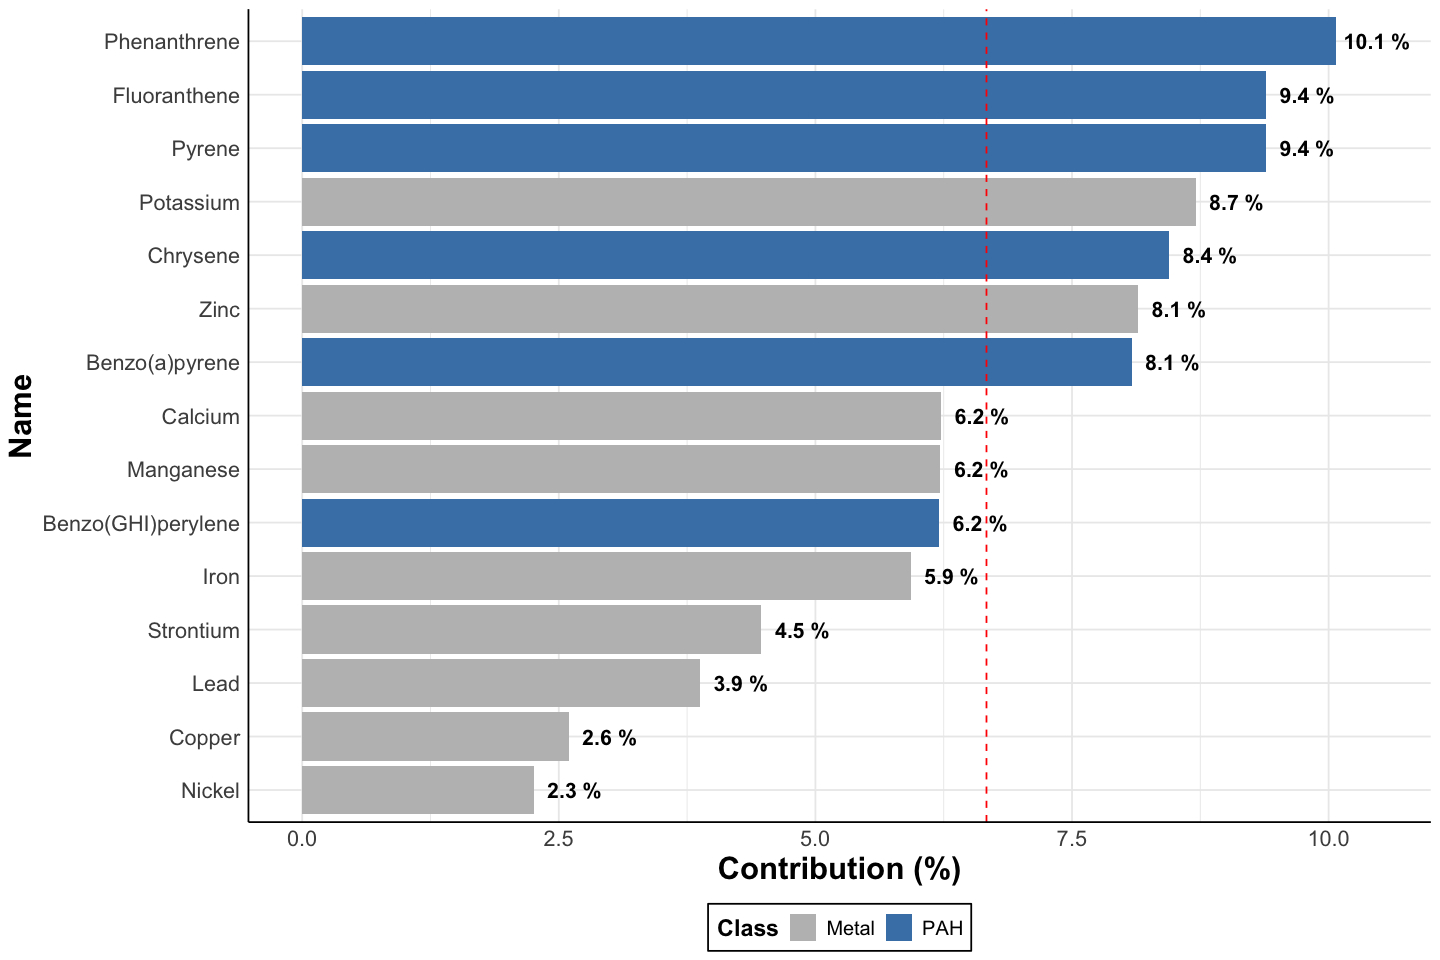

In [33]:
ggplot(vol_contrib_df, aes(x = Per_Contribution, y = reorder(Name, Per_Contribution))) + 
  geom_col(aes(fill = Class)) + 
  geom_vline(xintercept = mean(vol_contrib_df$Per_Contribution), linetype = "dashed", color = "red") + 
  geom_text(aes(x = Per_Contribution + 0.4, label = paste(round(Per_Contribution, 1), "%")), fontface = "bold", size = 4.5) + 

  theme_minimal() + 
  theme(legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", # changing legend position
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      axis.line = element_line(colour="black"), #making x and y axes black
      axis.text = element_text(size = 13), #changing size of x axis labels
      axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles

  labs(x = 'Contribution (%)', y = 'Name') + #changing axis labels 

  scale_fill_manual(values = c('Gray', "Steelblue"))

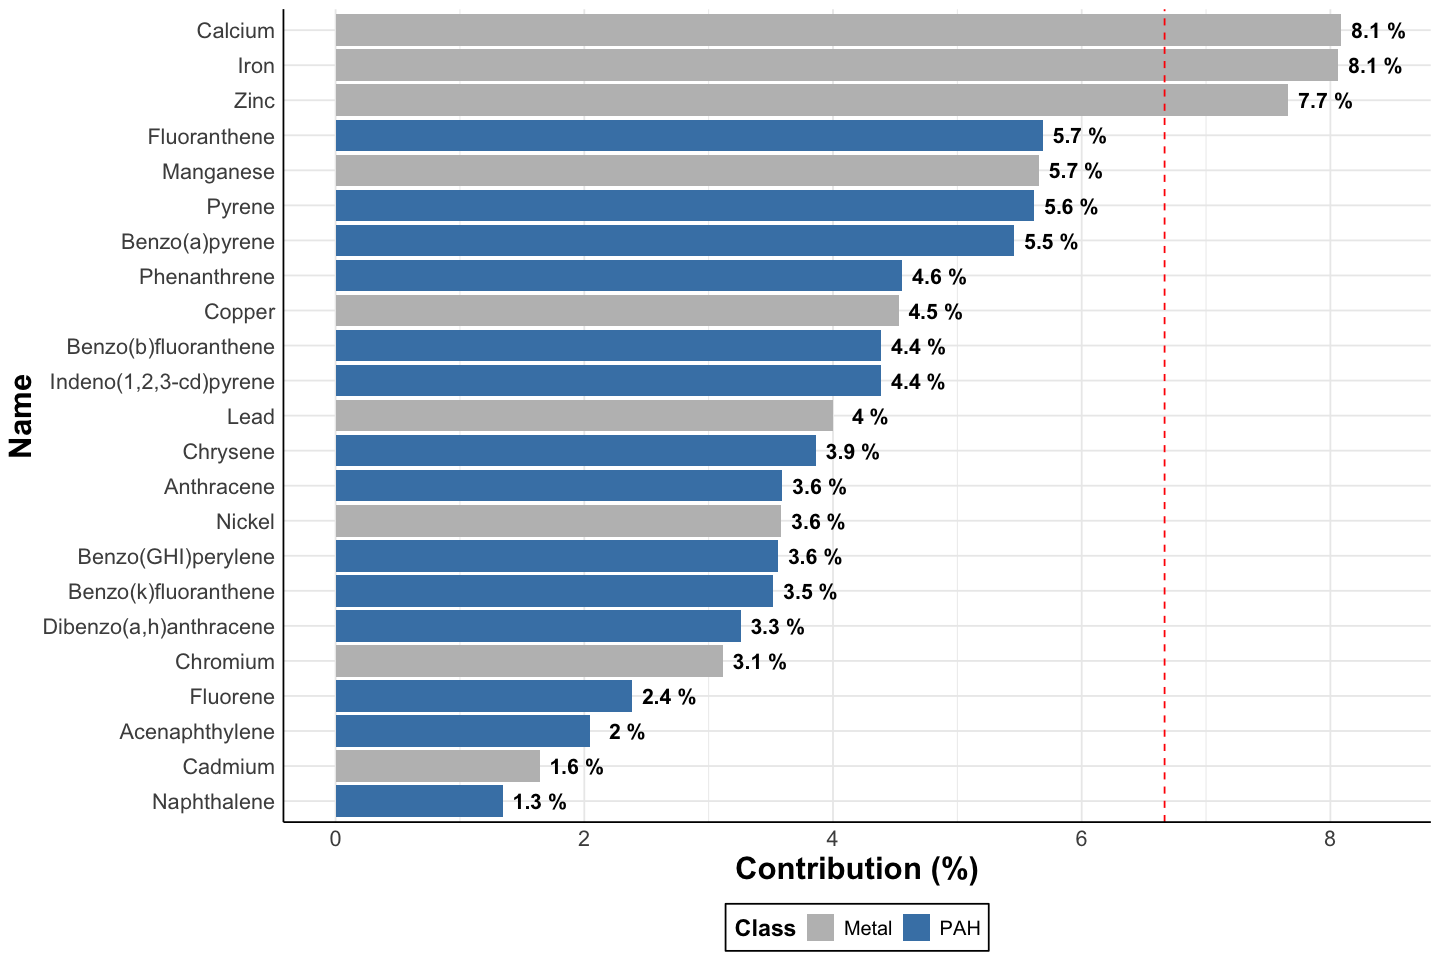

In [34]:
options(repr.plot.width=12, repr.plot.height=8) #changing size
ggplot(weight_contrib_df, aes(x = Per_Contribution, y = reorder(Name, Per_Contribution))) + 
  geom_col(aes(fill = Class)) + 
  geom_vline(xintercept = mean(vol_contrib_df$Per_Contribution), linetype = "dashed", color = "red") + 
  geom_text(aes(x = Per_Contribution + 0.3, label = paste(round(Per_Contribution, 1), "%")), fontface = "bold", size = 4.5) + 

  theme_minimal() + 
  theme(legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", # changing legend position
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      axis.line = element_line(colour="black"), #making x and y axes black
      axis.text = element_text(size = 13), #changing size of x axis labels
      axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles

  labs(x = 'Contribution (%)', y = 'Name') + #changing axis labels 

  scale_fill_manual(values = c('Gray', "Steelblue"))

Next: something that analyses all the metadata too